In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import re
import glob

In [6]:
def convergencia(tiempo, fotones, tol=1e-3, porcentaje=0.1):
    npoints = int(len(tiempo) * porcentaje)
    if npoints < 2:
        return False, np.nan # no hay suficientes puntos

    fotones = fotones[-npoints:]
    tiempo = tiempo[-npoints:]
    
    df = np.gradient(fotones, tiempo)
    df_mean = np.mean(np.abs(df))
    
    return df_mean < tol, df_mean

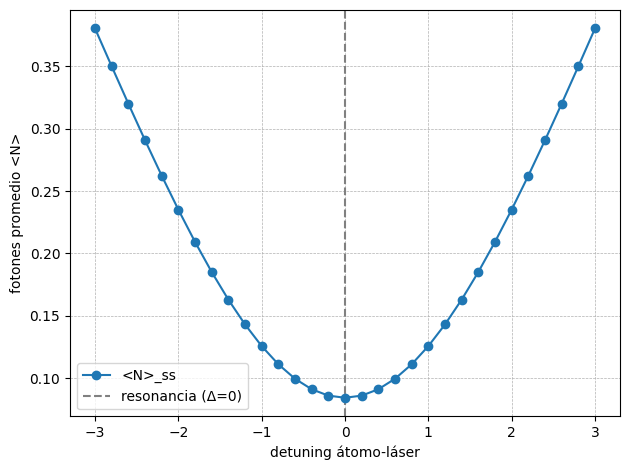

In [20]:
path = "1at2lvl/"
detunings = []
Nss = []
converged = []
non_converged = []

files = glob.glob(os.path.join(path, '*.h5'))
for file in files:
    with h5py.File(file, 'r') as f:
        dataset = os.path.basename(file).replace('.h5', '')
        detuning = f[dataset].attrs['detuning_al']
        tt = f[dataset].attrs['t']
        tiempo = np.linspace(float(tt[0]), float(tt[1]), int(tt[2]))

        if dataset not in f:
            print(f"  no se encontró el dataset '{dataset}' en el archivo. Saltando.")
            continue
            
        rho = f[dataset][:]
        N_expect = rho[:, 0]
        
        is_converged, derivative = convergencia(tiempo, N_expect)
        
        # promediamos el último 25% de los puntos para obtener el valor de N_ss
        npoints = int(len(N_expect) * 0.25)
        ns = np.mean(N_expect[-npoints:])
        detunings.append(detuning)
        Nss.append(ns)
        
        if is_converged:
            converged.append((detuning, Nss))
        else:
            print(f"  detuning={detuning_val:.2f} podría no haber convergido (derivada = {derivative:.2e})")
            non_converged.append((detuning, Nss))

# convierte a lista de numpy
detunings = np.array(detunings)
Nss = np.array(Nss)
# ordena por detuning para mejorar la gráfica
sorti = np.argsort(detunings)
detunings = detunings[sorti]
Nss = Nss[sorti]


plt.plot(detunings, Nss, 'o-', label='<N>_ss', zorder=5)
if non_converged:
    nc_det, nc_N = zip(*non_converged)
    plt.scatter(nc_det, nc_N, color='red', s=100, marker='x', label='no convergencia', zorder=10)

plt.axvline(0, color='gray', linestyle='--', label='resonancia (Δ=0)')
plt.xlabel("detuning átomo-láser")
plt.ylabel("fotones promedio <N>")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
#plt.savefig("espectro_cavidad.png", dpi=300)
plt.show()